# Deep neural network-based models for predicting mRNA editing with highly imbalanced data

Bidirectional LSTM with Attention Layer

In [ ]:
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [ ]:
########################################
# PARAMS
########################################
fname      = 'hg38_IMBALANCED.csv'
separator_char=';'
categories=[['A','G','C','T'],['s','d','h','i','b']]
padding=True
sample_frac = 1.0
ptrain     = 0.7
trace_level = 1
model_name = 'Imbalanced_LSTMBidiAttention'
num_lstm_units=256
n_epochs=40
#batch_size=32
batch_size=128
categories_size=20
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [ ]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Checking if GPU is available and GPU characteristics.

In [ ]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Wed Nov  9 08:24:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [ ]:
if padding==True:
    categories_size=21

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/RAND1000/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/RAND1000/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

Mounted at /content/drive


In [ ]:
from RNAEd import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 2 /categories: [['A', 'G', 'C', 'T'], ['s', 'd', 'h', 'i', 'b']]
Number of codes=21
('A', 's') / 0
('A', 'd') / 1
('A', 'h') / 2
('A', 'i') / 3
('A', 'b') / 4
('G', 's') / 5
('G', 'd') / 6
('G', 'h') / 7
('G', 'i') / 8
('G', 'b') / 9
('C', 's') / 10
('C', 'd') / 11
('C', 'h') / 12
('C', 'i') / 13
('C', 'b') / 14
('T', 's') / 15
('T', 'd') / 16
('T', 'h') / 17
('T', 'i') / 18
('T', 'b') / 19
('*', '*') / 20
Number of codes or categories size: 21


In [ ]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

LAST MODEL FILE: /content/drive/MyDrive/MODELS/Imbalanced_LSTMBidiAttention.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_Imbalanced_LSTMBidiAttention.h5


We read the data.

In [ ]:
print("DATASET: {}".format(datafile))
data_all = pd.read_csv(datafile,sep=separator_char)
print(data_all.head)

DATASET: /content/drive/MyDrive/DATASETS/RAND1000/W50/hg38_IMBALANCED.csv
<bound method NDFrame.head of                              GENE     POS  EDITING  P1  P2  P3  P4  P5  P6  \
0                     ZPLD1_ZPLD1   46079        0  17   7   2   7   7   2   
1                     TASP1_TASP1  457830        0   7  17  12  17  17  17   
2                   CHCHD3_CHCHD3  269432        0   2  12   2   7   7  17   
3       LOC105372889_LOC105372889    6336        0  18  11  16   3  16  11   
4                   TTTY22_TTTY22    6988        0  16   3  16   6  16   6   
...                           ...     ...      ...  ..  ..  ..  ..  ..  ..   
300169          ENPP7P10_ENPP7P10   27134        0  12  12   2   7  17  12   
300170                SASH1_SASH1  110179        0   6   6  13   3   6   1   
300171  LOC107984428_LOC107984428   14335        0  11  16  16   6   6  16   
300172              SLC2A2_SLC2A2   19639        0  11  11  11  16  11  11   
300173                SASH1_SASH1  117

In [ ]:
print("shape data_all={}".format(data_all.shape))

shape data_all=(300174, 104)


We sample a subset

In [ ]:
data = data_all.sample(frac=sample_frac)
print("shape data={}".format(data.shape))

shape data=(300174, 104)


In [ ]:
neg, pos = np.bincount(data['EDITING'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 300174
    Positive: 6904 (2.30% of total)



In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.74899273])

In [ ]:
# Train and Validation+Test
data_train, data_val_test, data_y_train, data_y_val_test = train_test_split(data, data['EDITING'], test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
data_val, data_test, data_y_val, data_y_test = train_test_split(data_val_test, data_y_val_test, test_size=0.5, random_state=random_seed)

print("data_train:{} data_y_train:{}".format(data_train.shape,data_y_train.shape))
print("data_val: {} data_y_val: {}".format(data_val.shape,data_y_val.shape))
print("data_test: {} data_y_test: {}".format(data_test.shape,data_y_test.shape))
print("TRAIN LABELS:")
print(data_y_train.value_counts())
print("VALIDATION LABELS:")
print(data_y_val.value_counts())
print("TEST LABELS:")
print(data_y_test.value_counts())

data_train:(210121, 104) data_y_train:(210121,)
data_val: (45026, 104) data_y_val: (45026,)
data_test: (45027, 104) data_y_test: (45027,)
TRAIN LABELS:
0    205310
1      4811
Name: EDITING, dtype: int64
VALIDATION LABELS:
0    43967
1     1059
Name: EDITING, dtype: int64
TEST LABELS:
0    43993
1     1034
Name: EDITING, dtype: int64


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [ ]:
#DataGenerator converts on the fly from raw data to one-hot
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = data_train.iloc[:,3:].shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(data_train.iloc[:,3:], data_y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(  data_val.iloc[:,3:], data_y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator( data_test.iloc[:,3:], data_y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Model defined from the scratch

In [ ]:
from keras.layers import *
from keras.models import *
from keras import backend as K

#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(0.2)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será de 1 batch=None numero de secuencias, 
#de 101 nucleosidos(timesteps=50+1+50) de 2 x número_unidades=2*256=512
#Es decir (None,101,512)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nucleósido, es decir, nos debe dar (101,1)
#Como son pesos probabilisticos deben sumar 1.
#Pero realmente no queremos esos pesos, sino la suma de los 101 hidden states 
#de dimensión 512 ponderados por esos pesos que es lo que conforma el verdadero contexto, 
# y que tendrá dimensión (None,1,512).
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (101,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#Pero ojo, esos no son los pesos de la red neuronal de la capa de atención, porque si nuestra
#red neuronal de atención tuviera 101 pesos, serían posicionales y deben ser calculados por el 
#valor semántico de los nucleótidos (si fueran palabras por su significado, no por su posición)

#Nuestra red neuronal de atención debe atender al "significado" de las palabras, es decir,
#a la codificación de cada nucleótido en el vector de estados 
#de la LSTM que tiene dimensión 512. Por lo tanto el número de pesos de la  red de atención 
# es de (512,1). Son los pesos de las 512 conexiones de la neurona de esta capa.

#Durante el entrenamiento multiplicaremos matricialmente todos los nucleótidos de la 
#secuencia (101), con su codificación LSTMbidi(512), por los pesos de la capa de atención(512) y eso 
#nos dará los 101 pesos de atención:
#(101,512) x (512,1) = (101,1) los pesos de atención
#(512,1) son los pesos de la capa.

#Ahora entendemos por qué los pesos de atención no son constantes
#sino que para cada secuencia cambian:
#En una red ya entrenada:
#  (101,512)[variable] x (512,1)[constante] = (101,1)[variable]

#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout) #Capa de atención
e=Flatten()(e)
a=Activation('softmax')(e) #Softmax para que sumen 1 los pesos de atención.
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with LSTM layer o/p
output = Multiply()([dropout, temp])
# Get the attention adjusted output state by adding up
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
output_bias=initial_bias
output_bias = tf.keras.initializers.Constant(output_bias)
outputs= layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "Imbalanced_LSTMBidiAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                                   

In [ ]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [ ]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0

if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


if best_model_accuracy > last_model_accuracy:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "Imbalanced_LSTMBidiAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                          

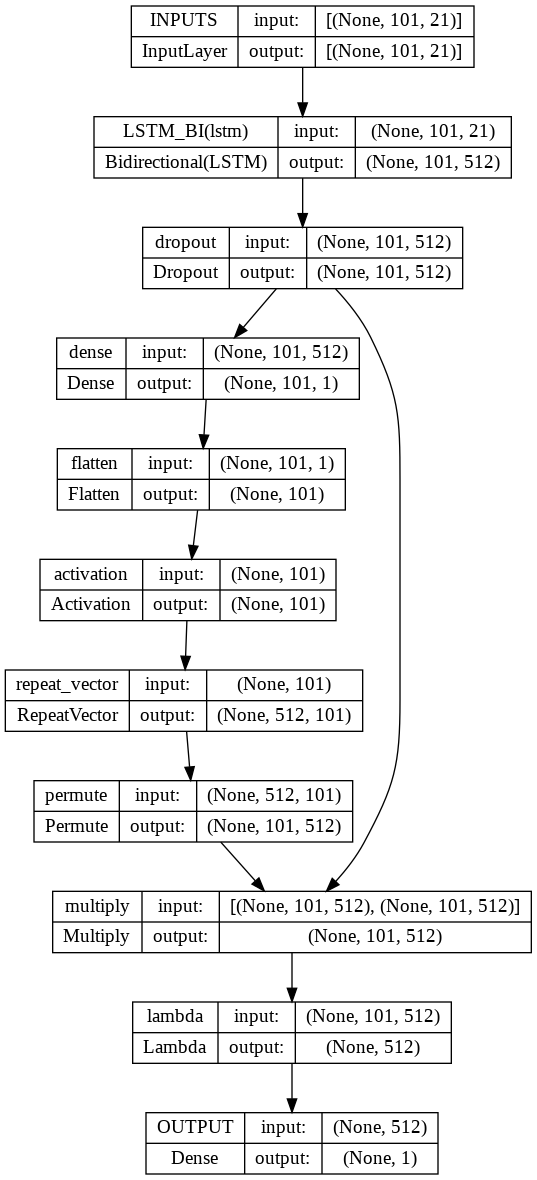

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

We will use always the same initial weights for results be comparable between models

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)
print(initial_weights)

/tmp/tmp7epy53xs/initial_weights


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 21.74


In [23]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],
                      class_weight=class_weight,
                      verbose=trace_level)

Epoch 1/40
1641/1641 [==============================] - ETA: 0s - loss: 0.5253 - binary_accuracy: 0.6833
Epoch 1: val_loss improved from inf to 0.49953, saving model to /content/drive/MyDrive/MODELS/best_model_Imbalanced_LSTMBidiAttention.h5
1641/1641 [==============================] - 826s 498ms/step - loss: 0.5253 - binary_accuracy: 0.6833 - val_loss: 0.4995 - val_binary_accuracy: 0.6772
Epoch 2/40
1641/1641 [==============================] - ETA: 0s - loss: 0.4550 - binary_accuracy: 0.7399
Epoch 2: val_loss improved from 0.49953 to 0.42448, saving model to /content/drive/MyDrive/MODELS/best_model_Imbalanced_LSTMBidiAttention.h5
1641/1641 [==============================] - 799s 487ms/step - loss: 0.4550 - binary_accuracy: 0.7399 - val_loss: 0.4245 - val_binary_accuracy: 0.7613
Epoch 3/40
1641/1641 [==============================] - ETA: 0s - loss: 0.4236 - binary_accuracy: 0.7679
Epoch 3: val_loss did not improve from 0.42448
1641/1641 [==============================] - 783s 477ms/st

In [24]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 8 of 40


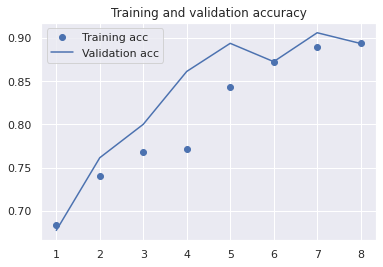

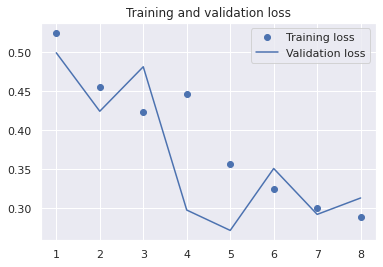

In [25]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [29]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [30]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
351/351 [==============================] - 133s 377ms/step - loss: 0.2715 - binary_accuracy: 0.8937
Accuracy on validation data: 0.894
Loss on validation data: 0.272


We make predictions on test data, never used during training nor validation

In [31]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
45027/45027 [==============================] - 494s 11ms/step


In [32]:
print(data_test.shape)
print(data_y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(45027, 104)
(45027,)
(45027, 1)
(45027, 1)


In [33]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(data_y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(data_y_test, model_prediction_binary))

MODEL Imbalanced_LSTMBidiAttention
---------------------------------
Kappa: 0.235
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     43993
           1       0.16      0.85      0.27      1034

    accuracy                           0.89     45027
   macro avg       0.58      0.87      0.60     45027
weighted avg       0.98      0.89      0.93     45027



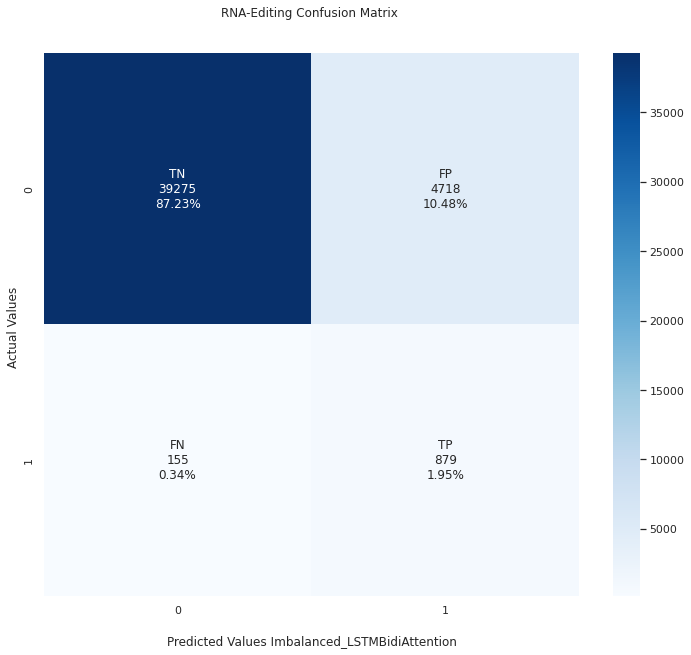

In [34]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(data_y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()

AUC: 0.92


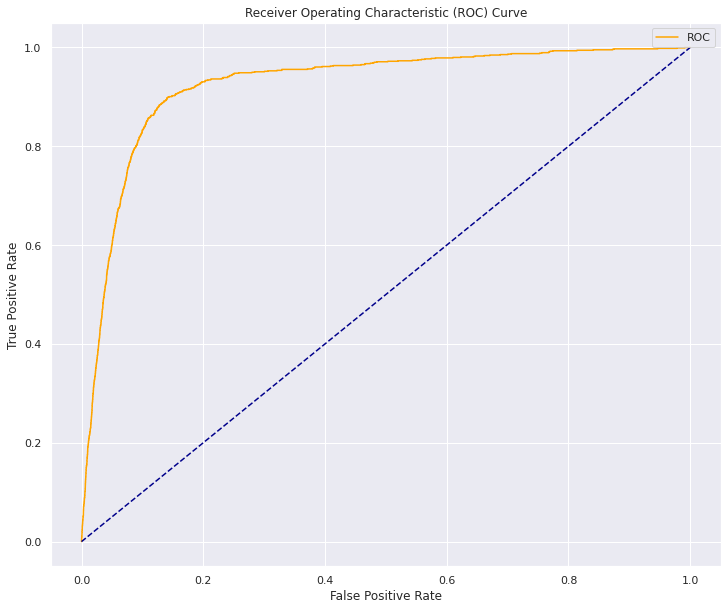

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(data_y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(data_y_test, model_prediction)
plot_roc_curve(fpr, tpr)


# RESULTS INSIGHT

In [38]:
results_data = data_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
230763,PRECSIT_PRECSIT,6062,0,None,0.180840,4,6,6,11,19,...,6,16,18,18,3,13,8,3,11,11
225744,TASP1_TASP1,16708,0,None,0.314073,6,16,11,11,11,...,11,8,8,3,11,1,11,1,13,3
214179,LOC105374989_LOC105374989,2359,0,None,0.132353,0,0,10,0,5,...,2,2,7,12,17,7,7,7,7,2
257998,STOX1_STOX1,61701,1,None,0.687959,6,16,11,18,8,...,13,1,6,6,11,16,2,2,17,17
100517,LOC105369844_LOC105369844,195780,0,None,0.043812,10,10,0,0,10,...,6,19,1,11,6,6,1,11,13,11


In [39]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and data_y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and data_y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and data_y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and data_y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
230763,PRECSIT_PRECSIT,6062,0,TN,0.180840,4,6,6,11,19,...,6,16,18,18,3,13,8,3,11,11
225744,TASP1_TASP1,16708,0,TN,0.314073,6,16,11,11,11,...,11,8,8,3,11,1,11,1,13,3
214179,LOC105374989_LOC105374989,2359,0,TN,0.132353,0,0,10,0,5,...,2,2,7,12,17,7,7,7,7,2
257998,STOX1_STOX1,61701,1,TP,0.687959,6,16,11,18,8,...,13,1,6,6,11,16,2,2,17,17
100517,LOC105369844_LOC105369844,195780,0,TN,0.043812,10,10,0,0,10,...,6,19,1,11,6,6,1,11,13,11


In [40]:
#Save the results into a file
report_dir="/content/drive/MyDrive/REPORT"
results_csv_file  =model_name + "_Results.csv"
results_excel_file=model_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [41]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

rowid best TP = 256228
GENE           RNF8_RNF8
POS                31467
EDITING                1
RESULT_TYPE           TP
PROB_PRED        0.98031
                 ...    
P97                    6
P98                   11
P99                    1
P100                  13
P101                   3
Name: 256228, Length: 106, dtype: object


In [42]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])

rowid best TN = 53621
GENE           IGSF21_IGSF21
POS                   251694
EDITING                    0
RESULT_TYPE               TN
PROB_PRED           0.006643
                   ...      
P97                        1
P98                        6
P99                        6
P100                       3
P101                       1
Name: 53621, Length: 106, dtype: object
